In [1]:
import os
import math
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta, time
os.environ['TZ'] ='America/New_York'

#import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from ib_async import *
util.startLoop()

In [2]:
ib = IB()
ib.connect(port=7496, clientId=3)

<IB connected to 127.0.0.1:7496 clientId=3>

Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1102, reqId -1: Connectivity between IBKR and Trader Workstation has been restored - data maintained. All data farms are connected: hfarm; usfarm.nj; cashfarm; usopt; usfarm; ushmds; secdefil.


In [3]:
def simple_data_req( contract, end_date , barsize ="5 mins", data_clean = True):

   
    df_acc=pd.DataFrame()
    df_hist=pd.DataFrame()

    for i in range(1):
        print(f'fetching data for {i}')
        end_date = end_date - timedelta(i)
        bars = ib.reqHistoricalData(contract= contract, endDateTime=end_date, barSizeSetting= barsize, durationStr= "230 D", whatToShow="TRADES", useRTH=True)
        df = util.df(bars)
        
        df_acc = pd.concat([df, df_acc], ignore_index=True)
        print(f'head date {df_acc.head(1)['date']}')
        print(f'tail date {df_acc.tail(1)['date']}')

    df_acc['Date_Only'] = df_acc['date'].dt.date
    
    if data_clean == True:
        df_hist = df_acc[(df_acc['date'].dt.time >= time(9, 30)) & (df_acc['date'].dt.time < time(16, 00))]
    else:
        df_hist = df_acc

    #df_hist.drop_duplicates(inplace=True)
    
    return df_hist

In [145]:
contract = Contract(symbol='META', secType='STK', exchange='SMART', currency='USD')
ib.qualifyContracts(contract)

[Contract(secType='STK', conId=107113386, symbol='META', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='META', tradingClass='NMS')]

In [146]:
now =datetime.now()
inferencing_date = now.date() 

In [147]:
df_stock = simple_data_req(contract, inferencing_date,)

fetching data for 0
head date 0   2024-05-21 09:30:00-04:00
Name: date, dtype: datetime64[ns, US/Eastern]
tail date 17831   2025-04-22 15:55:00-04:00
Name: date, dtype: datetime64[ns, US/Eastern]


In [ ]:
# capturing yesterday price close and today's open difference

In [148]:
df_temp = df_stock.copy()

In [149]:
df_stock= df_temp

In [150]:
#df_stock['diff_close_open'] = df_stock['open'] - df_stock['close'].shift(1)
#df_stock['diff_close_open'] = df_stock['diff_close_open'].shift(2)

In [151]:
df_stock.iloc[77:81]

,date,open,high,low,close,volume,average,barCount,Date_Only
77,2024-05-21 15:55:00-04:00,464.62,465.15,464.39,464.75,289472.0,464.842,1869,2024-05-21
78,2024-05-22 09:30:00-04:00,467.67,471.05,467.34,469.67,550761.0,468.950,1938,2024-05-22
79,2024-05-22 09:35:00-04:00,469.54,470.90,468.69,470.58,196651.0,469.726,1070,2024-05-22
80,2024-05-22 09:40:00-04:00,470.55,470.72,468.77,469.80,176490.0,469.838,934,2024-05-22


In [152]:
def distance(data, acc_volume):
    buy = data.close -data.low
    sell = data.high - data.close
    #dist_BS = (buy - sell)*data.volume/acc_volume
    dist_BS = (buy - sell)
    return dist_BS

In [153]:
def mid_price(data):
    mid = (data.high+data.low)/2
    return mid

In [158]:
df_ST = df_stock.copy()

In [159]:


def feature_creation(df, initial_acc, barsize=5 , df_train=pd.DataFrame(), stock_flag=True ):

    acc_distance = 0
    acc_volume = 0
    mid = []

    df['diff_pr_close_open'] = (df['open'] - df['close'].shift(1))/df['open']*100
    
    df['diff_pr_close_open'] = df['diff_pr_close_open'].shift(initial_acc -1)

            

    
    for n in range(229):   #  takeing out the last period out
        flag = ''

        Period = int(30/barsize + 6*60/barsize)*n
        acc_volume =  df.iloc[[0 + Period,1 + Period, 2+ Period ]].volume.sum()
        mid = []

        
    # need to find acc_volume first        
        for i in range(initial_acc):
            dist_BS = distance(df.iloc[i+Period], acc_volume)
            acc_distance += dist_BS
            mid.append(mid_price(df.iloc[i+Period]))
        
        mid_price_adj = (mid[initial_acc-1]- mid[0])/mid[0]*100

        if stock_flag ==True:
            df['Target_30min'] = (df['close'] - df['close'].shift(-6))/df['close'] *100
            df['Target_15min'] = (df['close'] - df['close'].shift(-3))/df['close'] *100
            df['Target_1hr'] = (df['close'] - df['close'].shift(-12))/df['close'] *100
            df['Target_10min'] = (df['close'] - df['close'].shift(-2))/df['close'] *100

        
        df.loc[initial_acc + Period -1, 'acc_distance'] = acc_distance
        df.loc[initial_acc + Period -1, 'mid_price'] = mid_price_adj

        #if Period >= int(30/barsize + 6*60/barsize):
        #    df.loc[initial_acc + Period, 'diff_open_pr_close'] = (df_stock.iloc[Period]['open'] - df_stock.iloc[Period -1]['close'])/df_stock.iloc[Period -1]['close']*100

        df['diff_open_close'] = (df['close'] - df['open'].shift(initial_acc -1))/df['close']*100
        df['diff_open_1hr'] = df['open'].diff(1)/df['open']*100
        df['diff_open_2hr'] = df['open'].diff(2)/df['open']*100
        #df_dum =pd.DataFrame()
        #df_dum['open'] = df['open']

        
        df['diff_high_1hr'] = df['high'].diff(1)/df['high']*100
        df['diff_high_2hr'] = df['high'].diff(2)/df['high']*100

        df['diff_low_1hr'] = df['low'].diff(1)/df['low']*100
        df['diff_low_2hr'] = df['low'].diff(2)/df['low']*100
        
        df['diff_close_1hr'] = df['close'].diff(1)/df['close']*100
        df['diff_close_2hr'] = df['close'].diff(2)/df['close']*100






        

        df_select = pd.DataFrame(df.iloc[initial_acc+Period -1])

        df_train = pd.concat([df_train,df_select.T], ignore_index=True)

                    
    df_train['high'] = (df_train['high']-df_train['open'])/df_train['open']*100
    df_train['low'] = (df_train['low']-df_train['open'])/df_train['open']*100
    df_train['close'] = (df_train['close']-df_train['open'])/df_train['open']*100
    df_train['open'] = (df_train['open']-df_train['open'])/df_train['open']*100


    return df, df_train 


In [160]:
df_test, df_train = feature_creation(df_ST, 12)

In [161]:
df_test.iloc[77:91]

,date,open,high,low,close,volume,average,barCount,Date_Only,diff_pr_close_open,...,mid_price,diff_open_close,diff_open_1hr,diff_open_2hr,diff_high_1hr,diff_high_2hr,diff_low_1hr,diff_low_2hr,diff_close_1hr,diff_close_2hr
77,2024-05-21 15:55:00-04:00,464.62,465.15,464.39,464.75,289472.0,464.842,1869,2024-05-21,0.002151,...,NaN,-0.040882,0.118376,0.055960,0.051596,0.159088,0.176576,0.092595,0.002152,0.154922
78,2024-05-22 09:30:00-04:00,467.67,471.05,467.34,469.67,550761.0,468.950,1938,2024-05-22,0.006456,...,NaN,1.056061,0.652169,0.769774,1.252521,1.303471,0.631232,0.806693,1.047544,1.049673
79,2024-05-22 09:35:00-04:00,469.54,470.90,468.69,470.58,196651.0,469.726,1070,2024-05-22,-0.002152,...,NaN,1.249522,0.398262,1.047834,-0.031854,1.221066,0.288037,0.917451,0.193378,1.238897
80,2024-05-22 09:40:00-04:00,470.55,470.72,468.77,469.80,176490.0,469.838,934,2024-05-22,-0.002151,...,NaN,1.062154,0.214642,0.612050,-0.038239,-0.070105,0.017066,0.305054,-0.166028,0.027671
81,2024-05-22 09:45:00-04:00,469.82,470.85,469.25,470.00,136872.0,469.984,796,2024-05-22,0.008607,...,NaN,1.114894,-0.155379,0.059597,0.027610,-0.010619,0.102291,0.119339,0.042553,-0.123404
82,2024-05-22 09:50:00-04:00,470.00,470.35,468.35,469.11,101866.0,469.551,577,2024-05-22,0.008610,...,NaN,0.963527,0.038298,-0.117021,-0.106304,-0.078665,-0.192164,-0.089677,-0.189721,-0.147087
83,2024-05-22 09:55:00-04:00,469.11,469.12,467.81,468.62,83434.0,468.445,482,2024-05-22,0.004302,...,NaN,0.787418,-0.189721,-0.151350,-0.262193,-0.368776,-0.115431,-0.307817,-0.104562,-0.294482
84,2024-05-22 10:00:00-04:00,468.61,469.10,468.15,468.59,75791.0,468.639,462,2024-05-22,-0.006449,...,NaN,0.725581,-0.106699,-0.296622,-0.004263,-0.266468,0.072626,-0.042721,-0.006402,-0.110971
85,2024-05-22 10:05:00-04:00,468.36,469.75,468.18,469.46,92968.0,469.092,530,2024-05-22,-0.004300,...,NaN,0.924466,-0.053378,-0.160133,0.138371,0.134114,0.006408,0.079029,0.185319,0.178929
86,2024-05-22 10:10:00-04:00,469.54,471.17,469.35,470.67,159117.0,470.467,803,2024-05-22,-0.004307,...,NaN,1.340642,0.251310,0.198066,0.301377,0.439332,0.249281,0.255673,0.257080,0.441923


In [162]:
df_train.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'average', 'barCount',
       'Date_Only', 'diff_pr_close_open', 'Target_30min', 'Target_15min',
       'Target_1hr', 'Target_10min', 'acc_distance', 'mid_price',
       'diff_open_close', 'diff_open_1hr', 'diff_open_2hr', 'diff_high_1hr',
       'diff_high_2hr', 'diff_low_1hr', 'diff_low_2hr', 'diff_close_1hr',
       'diff_close_2hr'],
      dtype='object')

In [163]:
df_train['Target_15min_cat'] = np.where(df_train['Target_15min'] > 0, 1, 0)
df_train['Target_30min_cat'] = np.where(df_train['Target_30min']  > 0, 1, 0)
df_train['Target_1hr_cat'] = np.where(df_train['Target_1hr'] > 0, 1, 0)
df_train['Target_10min_cat'] = np.where(df_train['Target_10min']  > 0, 1, 0)

In [164]:
#df_train_clean = pd.concat([df_train, df_train_TQ_clean], axis=1)

df_model_train = df_train.drop(columns=['date', 'Date_Only'], axis=1)

In [165]:
df_model_train = df_model_train.astype(float)
#df_model_train.reset_index(inplace=True)
#df_model_train['Target_10min_cat'] = df_model_train['Target_10min_cat'].astype(int)

In [166]:
df_model_train

,open,high,low,close,volume,average,barCount,diff_pr_close_open,Target_30min,Target_15min,...,diff_high_1hr,diff_high_2hr,diff_low_1hr,diff_low_2hr,diff_close_1hr,diff_close_2hr,Target_15min_cat,Target_30min_cat,Target_1hr_cat,Target_10min_cat
0,0.0,0.064234,-0.111339,-0.062093,78252.0,466.968,467.0,NaN,-0.299946,-0.092126,...,-0.100569,-0.074892,-0.036440,0.079311,-0.077129,-0.010712,0.0,0.0,1.0,0.0
1,0.0,0.091225,-0.161236,0.059403,113447.0,471.376,550.0,0.624372,0.127216,0.286235,...,0.078425,0.044511,0.082873,0.031874,0.069969,0.125095,1.0,1.0,0.0,1.0
2,0.0,0.141014,-0.094009,0.132467,68876.0,468.291,361.0,1.076383,0.518500,-0.078948,...,0.119479,0.104544,0.102652,0.156116,0.151496,0.200572,0.0,1.0,0.0,0.0
3,0.0,0.202212,-0.075829,0.126382,114363.0,475.253,632.0,0.355088,-0.479647,-0.067319,...,0.138740,0.023123,0.158098,0.341491,0.119912,0.084149,0.0,0.0,0.0,0.0
4,0.0,0.115364,-0.119560,0.018878,52802.0,476.719,355.0,-0.344119,-0.020971,-0.085983,...,0.033522,0.031427,0.195304,0.140703,0.046137,0.048234,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,0.0,0.068511,-0.186503,-0.157957,163128.0,525.096,941.0,0.005655,0.810095,0.388845,...,-0.367046,-0.627591,-0.131559,-0.535769,-0.177268,-0.571832,1.0,1.0,1.0,1.0
225,0.0,0.148400,-0.134731,-0.134731,97780.0,512.349,522.0,0.000000,0.488816,0.482950,...,0.124783,0.202773,0.058658,0.195526,-0.146645,-0.041061,1.0,1.0,1.0,1.0
226,0.0,0.127531,-0.067751,0.013949,76955.0,502.025,546.0,0.017964,0.348668,0.097627,...,0.101497,0.276628,0.189432,0.446660,0.039848,0.207208,1.0,1.0,0.0,0.0
227,0.0,0.031057,-0.089031,0.006211,51918.0,482.875,293.0,0.000000,-0.107658,0.093166,...,-0.184215,-0.331174,-0.049736,-0.256968,-0.012422,-0.211176,1.0,0.0,0.0,1.0


In [167]:
X = df_model_train.drop(['open','Target_30min','Target_1hr', 'Target_30min_cat','Target_1hr_cat','Target_15min', 'Target_15min_cat','Target_10min', 'Target_10min_cat'], axis=1)  
#y = df_option['Target_std']
y = df_model_train['Target_30min_cat']

In [168]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [169]:
X_train.shape

(183, 18)

In [170]:
X_train

,high,low,close,volume,average,barCount,diff_pr_close_open,acc_distance,mid_price,diff_open_close,diff_open_1hr,diff_open_2hr,diff_high_1hr,diff_high_2hr,diff_low_1hr,diff_low_2hr,diff_close_1hr,diff_close_2hr
150,0.079891,-0.073233,0.063247,15917.0,600.933,116.0,-0.003320,48.41,-0.238263,-0.186294,0.083220,-0.109850,-0.008315,-0.046566,0.124921,0.109930,0.033267,0.141384
55,0.089242,-0.064022,0.069842,69520.0,515.568,413.0,-0.003908,20.18,0.711111,0.773541,-0.038801,0.031041,0.027137,-0.029075,0.023296,-0.001941,0.079487,0.042651
165,0.009697,-0.124440,-0.124440,22120.0,618.475,175.0,-0.017863,75.93,0.286224,0.357605,0.084038,0.114744,-0.084030,0.024239,-0.038835,0.024272,-0.129450,-0.040453
69,0.107163,-0.049754,-0.022963,17158.0,522.756,104.0,-0.001905,19.21,-0.361217,-0.453632,0.099508,0.055495,0.072640,0.072640,0.049779,0.076583,-0.013398,0.059336
167,0.063482,-0.036502,0.034915,28699.0,630.206,183.0,0.009532,76.30,0.197156,0.141198,0.092049,0.138073,-0.011102,0.155432,0.058742,0.225443,0.026970,0.141198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.041451,-0.008636,0.041451,13662.0,579.067,52.0,-0.017324,28.59,0.231936,0.341833,-0.008636,0.062177,-0.018991,0.015538,0.005182,0.055273,0.053519,0.043161
14,0.000000,-0.330516,-0.239476,123257.0,504.441,648.0,-0.493862,4.93,0.664531,0.777685,0.453223,0.639262,-0.011875,0.409682,0.172756,0.377284,-0.238067,0.255922
92,0.171182,-0.029695,0.141487,25346.0,572.945,164.0,-0.003478,26.94,-0.292390,-0.313972,-0.029695,-0.026201,0.085445,0.094164,0.001747,-0.013978,0.141287,0.094192
179,0.092328,-0.009792,0.043366,48408.0,715.141,271.0,-0.015297,73.01,-0.419829,-0.550933,0.022383,-0.037771,0.009783,0.043326,0.043371,0.034976,0.048941,0.068517


In [171]:
y_train.shape

(183,)

In [172]:
import xgboost as xgb


from sklearn.metrics import accuracy_score

# Load the iris dataset



# Split data into training and testing sets

# Create an XGBoost classifier
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Specify the objective function for multi-class classification               # Specify the number of classes
    n_estimators=100,           # Number of boosting rounds (trees)
    learning_rate=0.1,          # Step size shrinkage to prevent overfitting
    max_depth=3,                # Maximum depth of a tree
    random_state=42             # Random seed for reproducibility
)

#model = XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.39


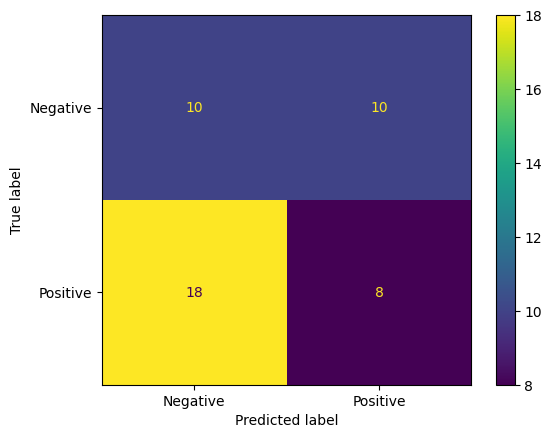

[[10 10]
 [18  8]]


In [173]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot()
plt.show()

# Print the confusion matrix
print(cm)

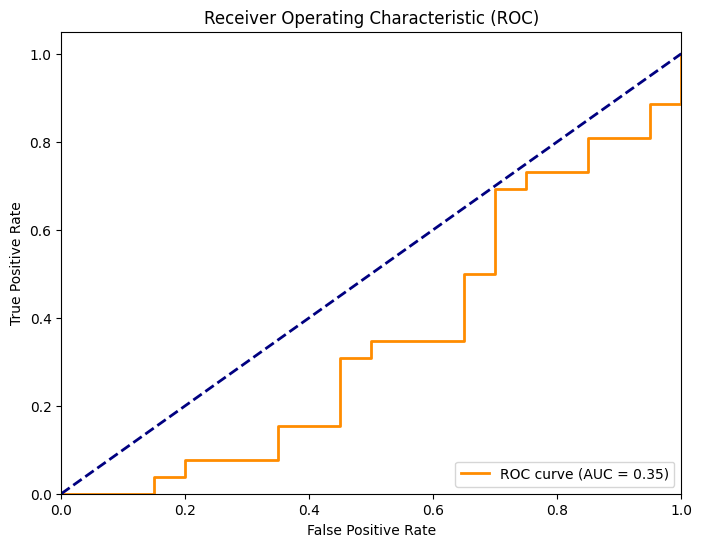

In [174]:

from sklearn.metrics import roc_curve, roc_auc_score

y_prob = model.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the AUC score
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

 thresholds

In [175]:
thresholds

array([       inf, 0.93464273, 0.82003725, 0.81927955, 0.78542674,
       0.75375366, 0.7155105 , 0.63388383, 0.6243053 , 0.5132069 ,
       0.51249075, 0.4946581 , 0.4691547 , 0.39466617, 0.39218953,
       0.33013448, 0.30864564, 0.30603614, 0.2852231 , 0.24859165,
       0.22720055, 0.17303813, 0.1615503 , 0.07642276], dtype=float32)

In [176]:
n_thresholds = thresholds[16:20]

In [177]:
n_thresholds =np.linspace(0.3, 0.2, 5)

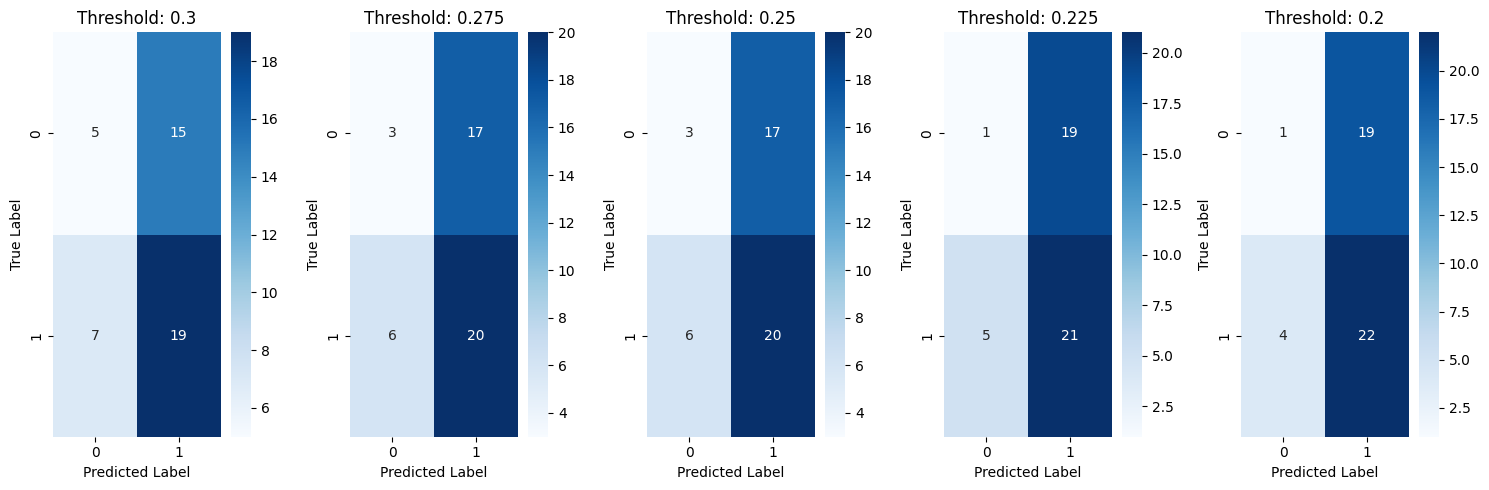

In [178]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, threshold, ax):
    """
    Calculates and plots the confusion matrix for given true and predicted labels at a specified threshold.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted probabilities.
        threshold (float): Probability threshold for classification.
        ax (matplotlib.axes._subplots.AxesSubplot): Axis object to plot on.
    """
    y_pred_class = (y_pred > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred_class)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Threshold: {threshold}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

# Example usage

fig, axes = plt.subplots(1, len(n_thresholds), figsize=(15, 5))

for i, threshold in enumerate(n_thresholds):
    plot_confusion_matrix(y_test, y_prob, threshold, axes[i])

plt.tight_layout()
plt.show()

In [179]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification


# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',  # Specify binary classification
    #eval_metric='accuracy',            # Evaluation metric
    #use_label_encoder=False,       # Avoid a warning
    random_state=42
)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1, # Use all available cores
    verbose=1
)

# Fit Grid Search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set (or the same data for demonstration)
y_prob = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print("AUC on the data:", auc_score)

Fitting 2 folds for each of 243 candidates, totalling 486 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Best score: 0.5628284758719542
AUC on the data: 0.2903846153846154


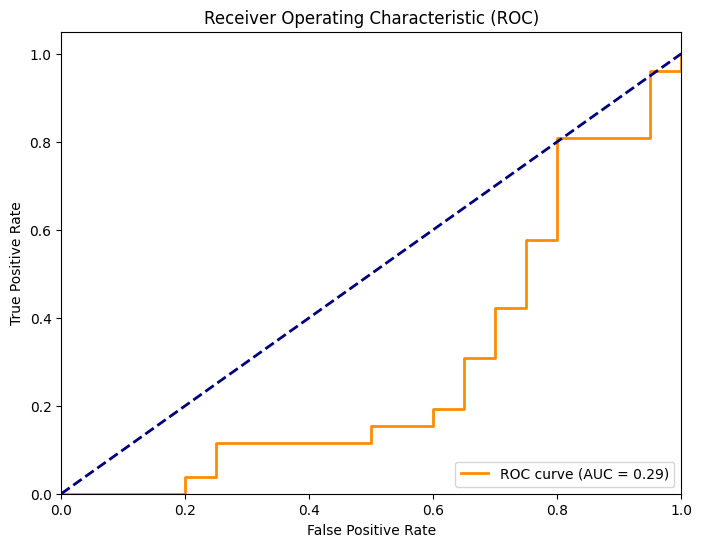

In [180]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the AUC score
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

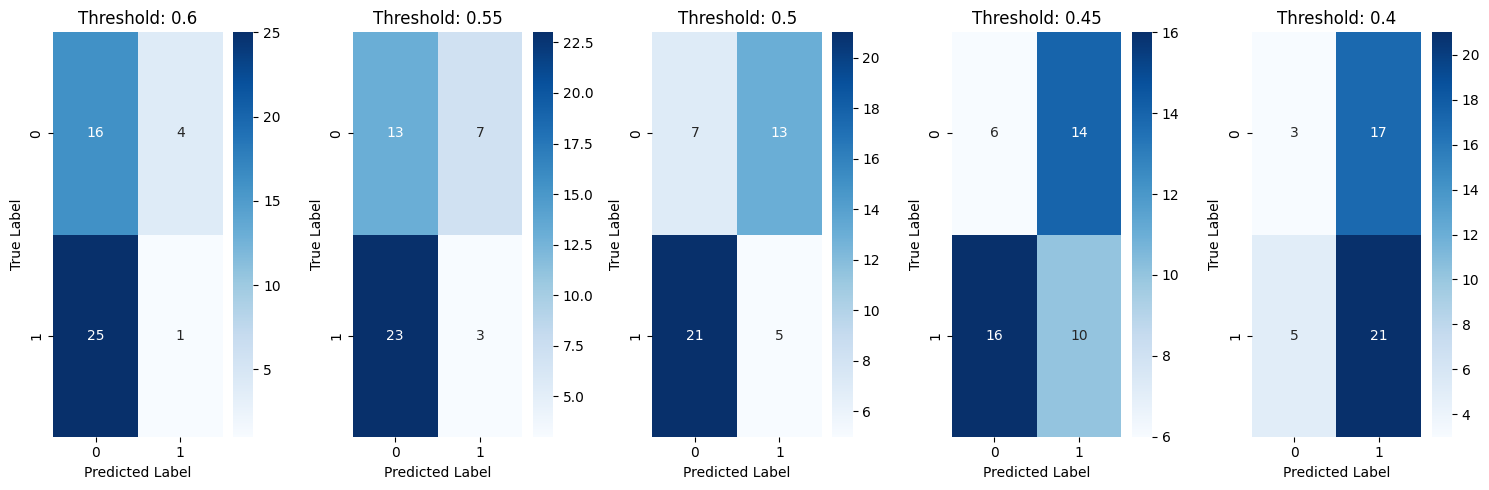

In [181]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

n_thresholds =np.linspace(0.6, 0.4, 5)

fig, axes = plt.subplots(1, len(n_thresholds), figsize=(15, 5))

for i, threshold in enumerate(n_thresholds):
    plot_confusion_matrix(y_test, y_prob, threshold, axes[i])

plt.tight_layout()
plt.show()

In [184]:
X

,high,low,close,volume,average,barCount,diff_pr_close_open,acc_distance,mid_price,diff_open_close,diff_open_1hr,diff_open_2hr,diff_high_1hr,diff_high_2hr,diff_low_1hr,diff_low_2hr,diff_close_1hr,diff_close_2hr
0,0.064234,-0.111339,-0.062093,78252.0,466.968,467.0,NaN,2.45,-0.314898,-0.203535,0.032117,-0.139174,-0.100569,-0.074892,-0.036440,0.079311,-0.077129,-0.010712
1,0.091225,-0.161236,0.059403,113447.0,471.376,550.0,0.624372,8.50,0.426262,0.841744,0.078496,0.169722,0.078425,0.044511,0.082873,0.031874,0.069969,0.125095
2,0.141014,-0.094009,0.132467,68876.0,468.291,361.0,1.076383,5.16,-0.975125,-0.900440,0.068370,0.025639,0.119479,0.104544,0.102652,0.156116,0.151496,0.200572
3,0.202212,-0.075829,0.126382,114363.0,475.253,632.0,0.355088,14.38,1.606280,1.653518,-0.027383,0.408636,0.138740,0.023123,0.158098,0.341491,0.119912,0.084149
4,0.115364,-0.119560,0.018878,52802.0,476.719,355.0,-0.344119,12.86,-0.385511,0.054526,0.033561,0.148925,0.033522,0.031427,0.195304,0.140703,0.046137,0.048234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,0.068511,-0.186503,-0.157957,163128.0,525.096,941.0,0.005655,98.31,-1.015946,-1.128414,-0.435809,-0.641343,-0.367046,-0.627591,-0.131559,-0.535769,-0.177268,-0.571832
225,0.148400,-0.134731,-0.134731,97780.0,512.349,522.0,0.000000,104.12,0.393998,0.353903,0.123016,0.070295,0.124783,0.202773,0.058658,0.195526,-0.146645,-0.041061
226,0.127531,-0.067751,0.013949,76955.0,502.025,546.0,0.017964,106.70,0.068774,0.181307,0.189303,0.394548,0.101497,0.276628,0.189432,0.446660,0.039848,0.207208
227,0.031057,-0.089031,0.006211,51918.0,482.875,293.0,0.000000,107.95,0.116115,0.244301,-0.215330,-0.281585,-0.184215,-0.331174,-0.049736,-0.256968,-0.012422,-0.211176


In [189]:
X_train.index

Index([150,  55, 165,  69, 167, 109, 124,  79,  86,  95,
       ...
       121, 228,  20, 188,  71, 106,  14,  92, 179, 102],
      dtype='int64', length=183)

In [196]:
X_train.iloc[174]

high                      0.159493
low                      -0.049842
close                    -0.011962
volume                69492.000000
average                 501.898000
barCount                328.000000
diff_pr_close_open        0.006044
acc_distance            114.120000
mid_price                 0.730594
diff_open_close           1.034833
diff_open_1hr            -0.107658
diff_open_2hr            -0.303036
diff_high_1hr             0.051753
diff_high_2hr            -0.169191
diff_low_1hr              0.183508
diff_low_2hr             -0.035904
diff_close_1hr           -0.011963
diff_close_2hr           -0.119634
Name: 228, dtype: float64

In [198]:
y_prob = best_model.predict_proba(X_train.iloc[174])[:, 1]

ValueError: feature_names mismatch: ['high', 'low', 'close', 'volume', 'average', 'barCount', 'diff_pr_close_open', 'acc_distance', 'mid_price', 'diff_open_close', 'diff_open_1hr', 'diff_open_2hr', 'diff_high_1hr', 'diff_high_2hr', 'diff_low_1hr', 'diff_low_2hr', 'diff_close_1hr', 'diff_close_2hr'] ['228']
expected diff_high_2hr, diff_close_1hr, diff_high_1hr, diff_open_close, diff_open_2hr, average, close, acc_distance, high, diff_low_2hr, mid_price, barCount, diff_pr_close_open, volume, diff_open_1hr, diff_low_1hr, low, diff_close_2hr in input data
training data did not have the following fields: 228

In [197]:
X_test.iloc[174]

IndexError: single positional indexer is out-of-bounds